# DASHBOARD
__This notebook is meant setup a training session and evaluate its performances__

----

Load python libraries

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session
import keras.losses as klosses
import keras.optimizers as koptimizers
import keras.callbacks as kcallbacks
import keras.initializers as initializers

Load and setup local dependencies

In [4]:
cur_dir = os.getcwd()
base_dir = os.path.dirname(cur_dir)

import sys
sys.path.append(base_dir)
from utils.LungsLoader import LungsLoader
from utils.ScanHandler import ScanHandler

import src.losses as reg_losses
from src.callbacks import OutputObserver
from src.training.config_file import ConfigFile
from src.training.luna_training import LunaTrainer
from src.evaluation.luna_testing import LunaTester

import warnings
warnings.filterwarnings("ignore")

loader = LungsLoader()
handler = ScanHandler(plt)

# Initialize a session

In [5]:
session_name = "seg_atlas_reg4_7"
config = ConfigFile(session_name)
config.setup_session()

# Build the model

In [6]:
from src.networks.networks_utils import blocks
from src.networks.MariaNet import MariaNet
from src.networks.DiffeomorphicUnet import DiffeomorphicUnet

__Setting up model hyperparameters :__

In [5]:
# MARIA NET HYPERPARAMETERS
input_shape = (64, 64, 64)

conv_block_kwgs = {
                    "activation": "LeakyReLU",
                    "activation_kwargs":{
                        "alpha": 0.3
                        },
                    "normalize": True,
                    "conv_kwargs": {
                      "kernel_size": 3,
                      "padding": "same",
                      "kernel_initializer": initializers.RandomNormal(mean=0.0, stddev=1e-5)
                      }
                    }
squeeze_ratio = 16
conv_block = blocks.ConvBlock(**conv_block_kwgs)
squeeze_block = blocks.SqueezeExciteBlock(ratio=squeeze_ratio)

enc_filters = [32, 64, 128, 32, 32]
enc_dilation = [(1, 1, 1), (1, 1, 1), (2, 2, 2), (3, 3, 3), (5, 5, 5)]
enc_params = [{"filters": n_filter, "dilation_rate": dil_rate} for (n_filter, dil_rate) in zip(enc_filters, enc_dilation)]

dec_filters = [128, 64, 32, 32, 32]
dec_params = [{"filters": n_filter} for n_filter in dec_filters]

def_flow_nf = 3
lin_flow_nf = 12

builder = MariaNet(input_shape=input_shape,
                   enc_params=enc_params,
                   dec_params=dec_params,
                   conv_block=conv_block,
                   squeeze_block=squeeze_block,
                   def_flow_nf=def_flow_nf,
                   lin_flow_nf=lin_flow_nf)

In [7]:
# UNET HYPERPARAMETERS
input_shape = (256, 256, 256)

conv_block_kwgs = {
                    "activation": "LeakyReLU",
                    "activation_kwargs":{
                        "alpha": 0.3
                        },
                    "normalize": True,
                    "conv_kwargs": {
                      "kernel_size": 3,
                      "padding": "same",
                      "kernel_initializer": initializers.RandomNormal(mean=0.0, stddev=1e-5)
                      }
                    }
conv_block = blocks.ConvBlock(**conv_block_kwgs)

enc_filters = [16, 32, 32, 32]

dec_filters = [32, 32, 32, 32, 16, 16]

flow_nf = 3

builder = DiffeomorphicUnet(input_shape=input_shape,
                            enc_nf=enc_filters,
                            dec_nf=dec_filters,
                            conv_block=conv_block,
                            flow_nf=flow_nf,
                            use_segmentation=True)

__Serialize model builder__

In [8]:
builder_path = os.path.join(config.session_dir, "builder.pickle")
builder.serialize(builder_path)

# Training parameters

__Training, validation, testing sets :__

In [9]:
all_ids = loader.get_scan_ids()
all_ids = all_ids[:167]
train_ids, val_ids = train_test_split(all_ids, test_size=0.4, random_state=777)
val_ids, test_ids = train_test_split(val_ids, test_size=0.5, random_state=777)

atlas_id = train_ids[39]
config.set_atlas_id(atlas_id)

pd.DataFrame(train_ids).to_csv(os.path.join(config.session_dir, LunaTrainer.train_ids_filename), index=False, header=False)
pd.DataFrame(val_ids).to_csv(os.path.join(config.session_dir, LunaTrainer.val_ids_filename), index=False, header=False)
pd.DataFrame(test_ids).to_csv(os.path.join(config.session_dir, LunaTester.test_ids_filename), index=True, header=False)

__Input Shape :__

In [10]:
config.set_input_shape(input_shape)

__Losses :__

In [11]:
losses = [klosses.mean_squared_error, klosses.mean_absolute_error, reg_losses.dice_score]
loss_weights = [1., 1e-4, 1e-7]

config.set_losses(losses)
config.set_loss_weights(loss_weights)

__Optimizer :__

In [12]:
optimizer = koptimizers.Adam(lr=1e-3, decay=1e-6)
config.set_optimizer(optimizer)

__Callbacks :__

In [13]:
checkpoints_dir = os.path.join(config.session_dir, ConfigFile.checkpoints_dirname)
observations_dir = os.path.join(config.session_dir, ConfigFile.observations_dirname)

save_callback = kcallbacks.ModelCheckpoint(os.path.join(checkpoints_dir, ConfigFile.checkpoints_format), 
                                           verbose=1, 
                                           save_best_only=False)
early_stopping = kcallbacks.EarlyStopping(monitor='loss',
                                          min_delta=1e-3,
                                          patience=20,
                                          mode='auto')
observer = OutputObserver(session_dir=config.session_dir,
                          input_shape=config.input_shape,
                          src_id=train_ids[24],
                          tgt_id=config.atlas_id,
                          use_segmentation=True,
                          src_filepath=ConfigFile.observations_format['src'],
                          tgt_filepath=ConfigFile.observations_format['tgt'],
                          pred_filepath=ConfigFile.observations_format['pred'],
                          grad_x_filepath=ConfigFile.observations_format['grad_x'],
                          grad_y_filepath=ConfigFile.observations_format['grad_y'],
                          pred_seg_filepath=ConfigFile.observations_format['pred_seg'])

callbacks = [save_callback, early_stopping, observer]
config.set_callbacks(callbacks)

__Training scope :__

In [14]:
config.set_initial_epoch(0)

In [15]:
epochs = 200
steps_per_epoch = len(train_ids)


config.set_epochs(epochs)
config.set_steps_per_epoch(steps_per_epoch)

__Serialize session configs__

In [16]:
config.serialize()

------------

# Monitoring

Choose session to monitor

In [73]:
session_name = "seg_atlas_reg4"
config = ConfigFile(session_name)

config_path = os.path.join(ConfigFile.bin_dir, session_name, ConfigFile.pickle_filename)
config.load(config_path)

Build model

In [74]:
from src.networks.MariaNet import MariaNet
from src.networks.DiffeomorphicUnet import DiffeomorphicUnet
builder = DiffeomorphicUnet(use_segmentation=True)
builder.load(os.path.join(config.session_dir, ConfigFile.builder_filename))

In [75]:
model = builder.build()

weights_path = os.path.join(config.session_dir, ConfigFile.checkpoints_dirname, "chkpt_18.h5")
model.load_weights(weights_path)

#### Visualization

> Training set

In [76]:
train_ids_path = os.path.join(config.session_dir, LunaTrainer.train_ids_filename)
train_ids = pd.read_csv(train_ids_path).values.squeeze()

In [77]:
scans_ids = random.choices(train_ids, k=2)

preproc_gen = loader.preprocess_scans(scans_ids, *config.input_shape, clipping=True)
atlas_gen = loader.preprocess_scans([config.atlas_id], *config.input_shape, clipping=True)
atlas_seg = loader.preprocess_segmentations([config.atlas_id], *config.input_shape)
src_tr = next(preproc_gen)[0][np.newaxis, :, :, :, np.newaxis]
tgt_tr = next(atlas_gen)[0][np.newaxis, :, :, :, np.newaxis]
tgt_seg_tr = next(atlas_seg)[0][np.newaxis, :, :, :, np.newaxis]

[pred_tgt_tr, deform_field_tr, pred_tgt_seg_tr] = model.predict([src_tr, tgt_tr, tgt_seg_tr]) 

<Figure size 432x288 with 0 Axes>

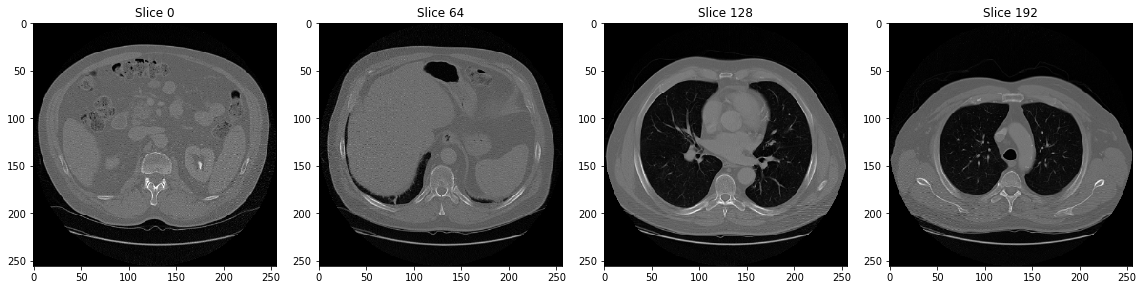

<Figure size 432x288 with 0 Axes>

In [78]:
handler.display_n_slices(src_tr.squeeze(), n=4)

<Figure size 432x288 with 0 Axes>

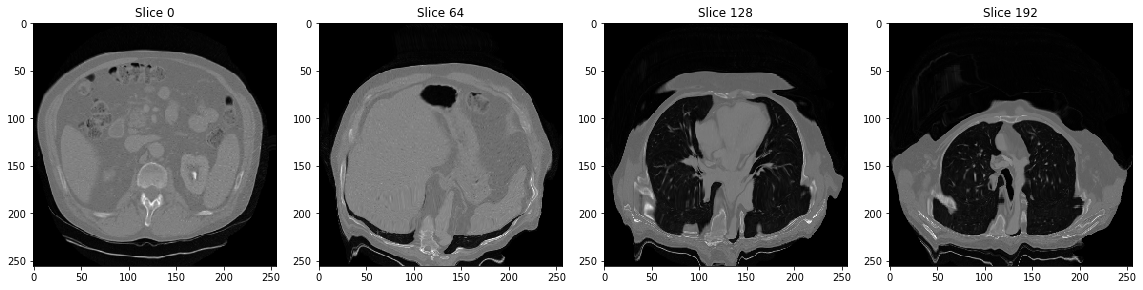

<Figure size 432x288 with 0 Axes>

In [79]:
handler.display_n_slices(pred_tgt_tr.squeeze(), n=4)

<Figure size 432x288 with 0 Axes>

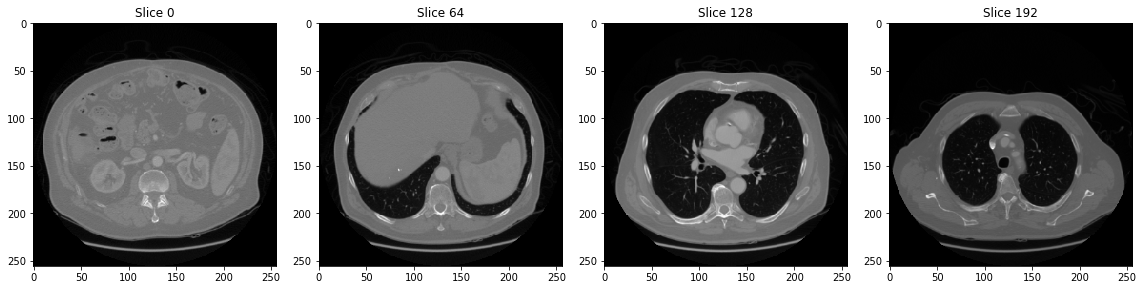

<Figure size 432x288 with 0 Axes>

In [80]:
handler.display_n_slices(tgt_tr.squeeze(), n=4)

> Testing set

In [8]:
test_ids_path = os.path.join(config.session_dir, LunaTester.test_ids_filename)
test_ids = pd.read_csv(test_ids_path).values.squeeze()

In [69]:
scans_ids = random.choices([test_ids[24]], k=1)

preproc_gen = loader.preprocess_scans(scans_ids, *config.input_shape, clipping=True)
atlas_gen = loader.preprocess_scans([config.atlas_id], *config.input_shape, clipping=True)

src_te = next(preproc_gen)[0][np.newaxis, :, :, :, np.newaxis]
tgt_te = next(atlas_gen)[0][np.newaxis, :, :, :, np.newaxis]

[pred_tgt_te, deform_field_tr] = model.predict([src_te, tgt_te]) 

<Figure size 432x288 with 0 Axes>

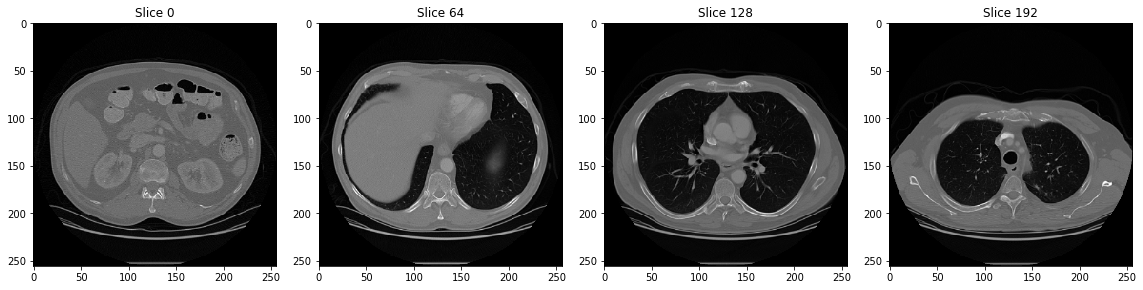

<Figure size 432x288 with 0 Axes>

In [70]:
handler.display_n_slices(src_te.squeeze(), n=4)

<Figure size 432x288 with 0 Axes>

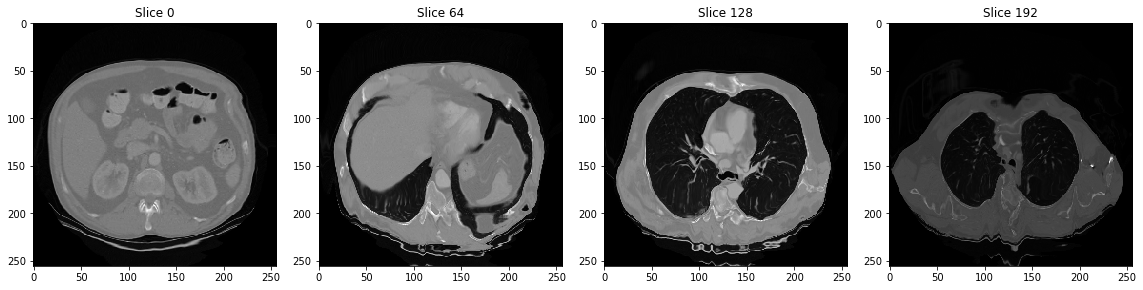

<Figure size 432x288 with 0 Axes>

In [71]:
handler.display_n_slices(pred_tgt_te.squeeze(), n=4)

<Figure size 432x288 with 0 Axes>

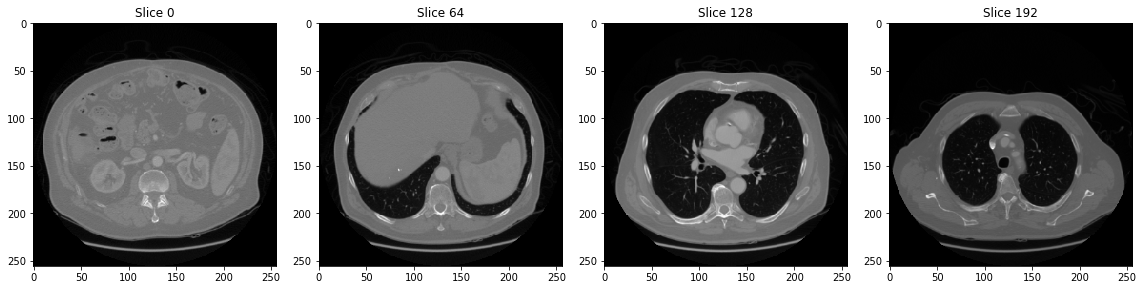

<Figure size 432x288 with 0 Axes>

In [72]:
handler.display_n_slices(tgt_te.squeeze(), n=4)

__Testing:__

In [55]:
test_metrics = LunaTester.reg_metrics

tester = LunaTester(model=model,
                    metric_dict=test_metrics,
                    config_path=os.path.join(config.session_dir, ConfigFile.pickle_filename))

In [58]:
scores_df = tester.evaluate(test_ids, generator="atlas", atlas_id=config.atlas_id)

Number of testing scans : 33

********** Beginning evaluation **********

Evaluated 0/33 scans

Evaluated 1/33 scans

Evaluated 2/33 scans

Evaluated 3/33 scans

Evaluated 4/33 scans

Evaluated 5/33 scans

Evaluated 6/33 scans

Evaluated 7/33 scans

Evaluated 8/33 scans

Evaluated 9/33 scans

Evaluated 10/33 scans

Evaluated 11/33 scans

Evaluated 12/33 scans

Evaluated 13/33 scans

Evaluated 14/33 scans

Evaluated 15/33 scans

Evaluated 16/33 scans

Evaluated 17/33 scans

Evaluated 18/33 scans

Evaluated 19/33 scans

Evaluated 20/33 scans

Evaluated 21/33 scans

Evaluated 22/33 scans

Evaluated 23/33 scans

Evaluated 24/33 scans

Evaluated 25/33 scans

Evaluated 26/33 scans

Evaluated 27/33 scans

Evaluated 28/33 scans

Evaluated 29/33 scans

Evaluated 30/33 scans

Evaluated 31/33 scans

Evaluated 32/33 scans

Evaluation completed !



In [60]:
scores_df

,mse,cross_correlation
0,0.611774,0.425334
1,0.187473,0.591698
2,0.633128,0.399534
3,0.597246,0.473662
4,0.110164,0.761979
5,0.113936,0.767850
6,0.594454,0.455035
7,0.098481,0.800341
8,0.558913,0.529451
9,0.500307,0.225563
